In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### PROMPT

Prompt:
> I have a codebase that simulates graphs and estimates parameters using several modules. In this codebase, the following files provide the necessary functionality:
>
> - src/degrees_counts.py
> Contains functions to compute the degree of a vertex and the sum of degrees for a given distance.
>
> - src/gic.py
> Defines a GraphInformationCriterion class that computes the spectral density of graphs and calculates divergence measures (KL, L1, L2) between spectra.
>
> - src/graph.py
> Implements a GraphModel class to generate graphs, add/remove edges using a logistic probability function, and methods to check convergence based on degree distribution, number of edges, and spectrum.
>
> - src/logit_estimator.py
> Contains classes for parameter estimation using negative log-likelihood loss and logistic regression on graphs, along with functions for computing edge probabilities.
>
> - src/model_selection.py
> Provides several model selection classes (e.g., RandomGraphModelSelector, ModelSelectorSpectrum, GraphModelSelection) which compare graph models such as ER, WS, BA, LG based on statistical properties (degree distribution, spectral density, etc.).
>
> - src/param_estimator.py
> Implements GraphParameterEstimator which searches for optimal model parameters (using grid or ternary search) by minimizing the GIC.
>
> - src/utils.py
> Contains helper functions for plotting graphs, spectra, degree distributions, and saving/loading graph artifacts.
>
> - notebooks/tests_dataset.py
> Runs experiments with real connectome graphs from data files, applies the graph generation and edge-population methods, and plots the evolution of spectral distances and model selection results.
>
> Task to Implement:
>
> Using the above codebase as a foundation, please write code (or design a plan) that performs the following experimental study:
>
> 1. ANOVA Experiment on Graph Estimation:
> - For each of the three different numbers of nodes: n = 100, 200, and 500, perform the following steps.
> - For each n, simulate a graph using the available methods (for example, by using the populate_edges_spectrum method from GraphModel in src/graph.py).
> - During each simulation, estimate the logistic regression parameter sigma (and compute its standard deviation and estimation values) using the methods provided in src/logit_estimator.py or related classes.
> - Repeat this simulation 1000 times to collect a distribution of estimated sigma values for each graph size.
>
> 2. ANOVA Analysis:
> - For the repeated simulations, perform an ANOVA analysis in a manner similar to how ANOVA is applied for logistic regression (i.e., comparing within-group and between-group variances).
> - Consider two scenarios:
> - Scenario A: The underlying model has two equal sigma parameters and a third different one (i.e., sigma1 = sigma2 ≠ sigma3).
> - Scenario B: All three sigma values are equal (i.e., sigma1 = sigma2 = sigma3).
> - Note that for Scenario B, you would expect the ANOVA to produce a diagonal ROC (i.e., no discrimination capability), while for Scenario A, the model should be able to detect significant differences.
>
> 3. ROC Curve Computation:
> - Based on the results of the ANOVA tests (or p-values from the test), generate one or more ROC curves.
> - The ROC curve should have:
> - X-axis: Range of p-value thresholds.
> - Y-axis: The number (or proportion) of rejections of the null hypothesis (i.e., cases where the test correctly identifies a significant difference).
> - Comment on the expectation: with a high number of nodes, the ROC curve should show higher performance (better discrimination), whereas for the case with all sigmas equal, the ROC should be close to a diagonal line.
>
> Implementation Details and Hints:
>
> - You should re-use as much as possible from the provided modules (for example, use GraphModel for graph simulation, LogitRegEstimator or similar classes for parameter estimation, and the GIC methods to compare spectra).
> - Use loops to vary n (nodes) and to perform 1000 simulation runs for each configuration.
> - Collect the statistics (mean, standard deviation, and p-value from the ANOVA test) for each simulation set.
> - After simulation, use an appropriate plotting library (for example, matplotlib) to generate the ROC curves, where each point corresponds to a p-value threshold and the corresponding rejection count.
> - Include detailed logging or printouts of intermediate values (e.g., current sigma estimates, ANOVA statistics, etc.) for debugging and analysis.
> - Optionally, integrate parts of the existing plotting functions from src/utils.py to visualize graphs and spectra if needed.
>
> Final Deliverable:
>
> Please provide a high-level design or pseudo-code (or a plan) outlining:
>
> - How the simulations will be structured,
> - How the experiments for different n and sigma configurations will be organized,
> - Which functions and classes from the provided codebase will be utilized/extended,
> - How the ANOVA and ROC analysis will be executed,
> - And any assumptions or modifications needed for coherence between the modules.
>
> End of Task.
>
> Feel free to ask clarifying questions if any part of the requirements is ambiguous.
---

### Code

In [7]:
"""
High-Level Experiment: ANOVA on Graph Estimation

For each n in [100, 200, 500], we simulate three sets of graphs (groups) where:
    - In Scenario A: Two groups have sigma_true = 0.5 and one has sigma_true = 1.0.
    - In Scenario B: All three groups have sigma_true = 0.5.
    
For each simulation replication:
    1. For each group, generate a graph using GraphModel.populate_edges_spectrum.
    2. Estimate sigma using LogitRegEstimator.
    3. Collect estimated sigmas.
    
After many replications, perform ANOVA (using scipy.stats.f_oneway) on the three groups’ estimates,
collect the p-value, and then compute an ROC-like curve by varying the p-value threshold.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import from our codebase:
import sys
sys.path.append("..")
from src.graph import GraphModel
from src.logit_estimator import LogitRegEstimator

# -------------------------------
# Simulation function for one run.
# -------------------------------
def run_simulation(n, sigma_true, d=1, warm_up=1000, max_iterations=5000, patience=10):
    """
    Generate a graph with n nodes using the specified true sigma and estimate sigma.
    - Uses GraphModel.populate_edges_spectrum (from src/graph.py) to simulate graph evolution.
    - Uses LogitRegEstimator (from src/logit_estimator.py) to estimate sigma.
    
    Returns:
        sigma_est: The estimated sigma value.
    """
    # Initialize graph simulation with the true sigma value:
    gm = GraphModel(n=n, d=d, sigma=sigma_true)
    
    # For simulation we use the current graph as the "real_graph" (this is an assumption 
    # for this experiment; the method may be adjusted if a different "real" graph should be used)
    graphs, spec, spectrum_diffs, best_iteration = gm.populate_edges_spectrum(
         warm_up=warm_up,
         max_iterations=max_iterations,
         patience=patience,
         real_graph=gm.graph
    )
    simulated_graph = graphs[best_iteration]
    
    # Estimate sigma using logistic regression.
    estimator_obj = LogitRegEstimator(simulated_graph, d=d)
    features, labels = estimator_obj.get_features_labels()
    # Here we use simple settings; parameters such as l1 weight and alpha can be tuned.
    _, params, _ = estimator_obj.estimate_parameters(features, labels)# l1_wt=0, alpha=0)
    sigma_est = params[0]  # As done in tests_dataset, sigma is taken as params[0]
    return sigma_est

In [8]:
# -------------------------------
# Experiment function that collects sigma estimates for 3 groups.
# -------------------------------
def run_experiment(n, scenario, num_reps=1000, d=1, warm_up=1000, max_iterations=5000, patience=10):
    """
    For a given graph size n and scenario, simulate replications to obtain sigma estimates.
    
    Parameters:
      - n: number of nodes.
      - scenario: "A" for sigma1=sigma2 != sigma3; "B" for sigma1 = sigma2 = sigma3.
      - num_reps: Number of replications.
    
    Returns:
      Three lists of estimated sigma (one per group).
    """
    # Set true sigma values for the groups based on scenario:
    if scenario == "A":
        sigma_group1 = -4
        sigma_group2 = -4
        sigma_group3 = -8  # different value
    elif scenario == "B":
        sigma_group1 = sigma_group2 = sigma_group3 = -4
    else:
        raise ValueError("Scenario must be either 'A' or 'B'.")
    
    estimates_g1, estimates_g2, estimates_g3 = [], [], []
    
    for rep in range(num_reps):
        sigma_est1 = run_simulation(n, sigma_group1, d, warm_up, max_iterations, patience)
        sigma_est2 = run_simulation(n, sigma_group2, d, warm_up, max_iterations, patience)
        sigma_est3 = run_simulation(n, sigma_group3, d, warm_up, max_iterations, patience)
        estimates_g1.append(sigma_est1)
        estimates_g2.append(sigma_est2)
        estimates_g3.append(sigma_est3)

        if rep % 50 == 0:
            print(f"n={n}, scenario={scenario}: Completed {rep} replications")
    
    # You can print summary statistics if needed:
    print(f"Group means for n={n}, scenario={scenario}:",
          np.mean(estimates_g1), np.mean(estimates_g2), np.mean(estimates_g3))
    
    # Return the three groups of sigma estimates.
    return estimates_g1, estimates_g2, estimates_g3

In [4]:
# -------------------------------
# Function to compute ROC curve (rejection rate vs. p-value threshold)
# -------------------------------
def compute_roc_curve(p_values, thresholds=np.linspace(0, 1, 101)):
    """
    Given a collection of ANOVA p-values across experiments, compute for each p-value threshold
    the proportion of experiments where the null hypothesis would be rejected.
    
    Returns:
       thresholds: array of p-value thresholds.
       rejection_rates: corresponding rejection rates (percent of p-values below each threshold).
    """
    rejection_rates = []
    for thresh in thresholds:
        rejections = np.mean(np.array(p_values) < thresh)
        rejection_rates.append(rejections)
    return thresholds, rejection_rates

In [11]:
# -------------------------------
# Main routine: Loop over n sizes and both scenarios,
# collecting p-values from repeated ANOVA tests.
# -------------------------------
#ns = [100, 200, 500]
ns = [100]
scenarios = ["A", "B"]  # A: sigma values differ, B: sigma values are the same
#scenarios = ["A"]

# Set number of experiments – each experiment groups several simulation replications.
num_experiments = 2
reps_per_experiment = 2

# LG params
d = 0
warm_up = 1000
max_iterations = 5000
patience = 10

# Dictionary to store ANOVA p-values for each combination:
results = {}

# First, run experiments and collect ANOVA p-values.
for scenario in scenarios:
    results[scenario] = {}
    for n in ns:
        exp_p_values = []
        print(f"\nRunning experiments for n={n} in Scenario {scenario}...")
        for exp in range(num_experiments):
            # Run a sub-experiment to generate three groups of sigma estimates:
            g1, g2, g3 = run_experiment(n, scenario, num_reps=reps_per_experiment,
                                         d=d, warm_up=warm_up,
                                         max_iterations=max_iterations, patience=patience)
            # Perform one-way ANOVA on the three groups.
            f_val, p_val = stats.f_oneway(g1, g2, g3)
            exp_p_values.append(p_val)
            print(f"  Experiment {exp+1}/{num_experiments}: F={f_val:.3f}, p={p_val:.3e}")
        results[scenario][n] = exp_p_values


Running experiments for n=100 in Scenario A...
iteration: 0
	 Spectrum difference: 0.0
	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:29 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan    

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

n=100,

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

Group 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:30 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

iteration: 1000
	 Spectrum difference: 0.0
iteration: 2000
	 Spectrum difference: 0.0
iteration: 3000
	 Spectrum difference: 0.0
iteration: 4000
	 Spectrum difference: 0.0
iteration: 5000
	 Spectrum difference: 0.0
Max iterations reached
	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:31 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
-----------------------------

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:31 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:31 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

iteration: 1000
	 Spectrum difference: 0.0
iteration: 2000
	 Spectrum difference: 0.0
iteration: 3000
	 Spectrum difference: 0.0
	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1      

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

n=100,

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

Group 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:32 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:33 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

n=100,

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:33 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:33 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

iterat

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

	 Best iteration: 0
	 Best spectrum difference: 0.0
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: y                Pseudo R-squared: inf     
Date:               2025-02-09 22:33 AIC:              2.2000  
No. Observations:   4950             BIC:              8.7072  
Df Model:           0                Log-Likelihood:   -0.10001
Df Residuals:       4949             LL-Null:          0.0000  
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     20.0000          Scale:            1.0000  
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
const     -10.8096    3.1621  -3.4184  0.0006  -17.0073  -4.6119
x1          0.0000       nan      nan     nan       nan      nan
x2          0.0000       nan      nan     nan       nan      nan

Group 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or p

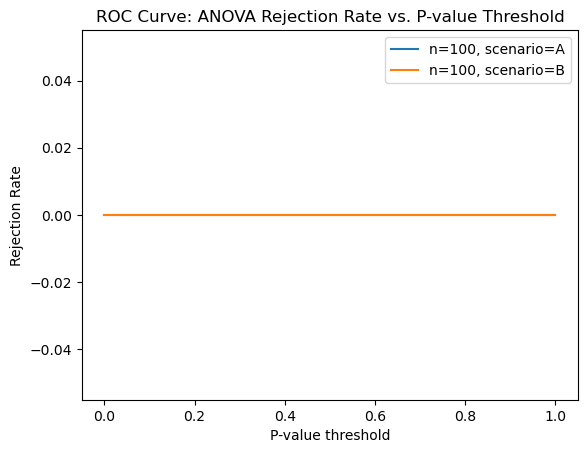

In [12]:
for scenario in scenarios:
    for n in ns:
        exp_p_values = results[scenario][n]
        thresholds, rejection_rates = compute_roc_curve(exp_p_values)
        plt.plot(thresholds, rejection_rates, label=f"n={n}, scenario={scenario}")

# Plot the ROC curves for all configurations.
plt.xlabel("P-value threshold")
plt.ylabel("Rejection Rate")
plt.title("ROC Curve: ANOVA Rejection Rate vs. P-value Threshold")
plt.legend()
plt.show()
